In [3]:
import glob, os
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
import matplotlib as mpl
from astropy import units as u
import speclite.filters
import time
import sncosmo

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
# mpl.rcParams["lines.linewidth"] = 1
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

In [5]:
from helper import makeSpecColors
from helper import convert_flam2fnu
from helper import get_wollaeger
from helper import convert_app2abs
from helper import convert_abs2app
kncbtbl = get_wollaeger()
from helper import get_bandwidth_table
bdwtbl = get_bandwidth_table()
#	speclite
from helper import get_speclite_med
meds = get_speclite_med()
mlam = meds.effective_wavelengths
mbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Med']*u.Angstrom
from helper import get_speclite_sdss
sdss = get_speclite_sdss()
slam = sdss.effective_wavelengths
sbdw = bdwtbl['bandwidth'][bdwtbl['group']=='SDSS']*u.Angstrom
from helper import get_speclite_jc
jc = get_speclite_jc()
jclam = jc.effective_wavelengths
jcbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Johnson Cousin']*u.Angstrom
from helper import get_speclite_lsst
lsst = get_speclite_lsst()
lsstlam = lsst.effective_wavelengths
from helper import get_lsst_depth
from helper import get_kmtnet_depth
from helper import get_7dt_depth
from helper import get_7dt_broadband_depth

from helper import get_speclite_lsst
lsst = get_speclite_lsst()
lsstlam = lsst.effective_wavelengths
from helper import get_lsst_depth
from helper import get_kmtnet_depth
from helper import get_lsst_bandwidth
lsstbdw = get_lsst_bandwidth()

In [6]:
def extract_fnu_from_simulation(psimtbl):
	fnuabs = np.array([(psimtbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in psimtbl.keys() if 't' != filte])
	return fnuabs

def extract_fnu_anwr_from_observation(pobstbl):
	fnuabs_anwr = np.array([(pobstbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in pobstbl.keys() if 'magabs' in filte])
	return fnuabs_anwr

def extract_fnu_from_observation(pobstbl):
	fnuobs = np.array([pobstbl[f"{filte}"].item() for filte in pobstbl.keys() if 'fnuobs_' in filte])
	fnuobserr = np.array([pobstbl[f"{filte}"].item() for filte in pobstbl.keys() if 'fnuerr_' in filte])
	return fnuobs, fnuobserr

def calc_colors(pobstbl, bd0, bd1, bd2):
	gr = (pobstbl[f'magobs_{bd0}']-pobstbl[f'magobs_{bd1}']).item()
	grerr = np.sqrt(
		(pobstbl[f'magerr_{bd0}']**2)+(pobstbl[f'magerr_{bd1}']**2)
	).item()
	ri = (pobstbl[f'magobs_{bd1}']-pobstbl[f'magobs_{bd2}']).item()
	rierr = np.sqrt(
		(pobstbl[f'magerr_{bd1}']**2)+(pobstbl[f'magerr_{bd2}']**2)
	).item()
	return gr, grerr, ri, rierr

def calc_chisq_all(fnuabs, popt, fnuobs, fnuobserr, dof):
	chisq = calc_chisquare(
		obs=fnuabs*popt,
		exp=fnuobs,
		obserr=fnuobserr,
		)

	rchisq = calc_redchisquare(
		obs=fnuabs*popt,
		exp=fnuobs,
		obserr=fnuobserr,
		dof=dof,
	)
	return chisq, rchisq

def generate_sncosmo_class(mdlname, ver, typ, z, t, peakabsmag=-19.0, peakabsfilter='bessellb'):
	"""
	peakabsfilter = 'bessellb'
	peakabsmag = -19.0
	"""
	#
	source = sncosmo.get_source(mdlname, version=ver)
	model = sncosmo.Model(source=source)
	model.set(z=z)
	model.set_source_peakabsmag(peakabsmag, peakabsfilter, 'ab')
	#
	tmin = model.mintime()
	tmax = model.maxtime()
	lmin = model.minwave()
	lmax = model.maxwave()

	#	Wavelength [AA]
	wavestep = 10
	wave = np.arange(lmin, lmax, wavestep)
	#	Time
	flux = model.flux(t, wave)
	# pflux, pwave = speclite_class.pad_spectrum(flux, wave)

	return flux, wave

In [7]:
path_obs='../5.result/kn_sim_cube_obs/med_iter100_40Mpc'
path_knsynpht='../3.table/kn_sim_cube_synphot'
path_knsp='../3.table/kn_sim_cube_lite'
path_snsynpht='../3.table/sn_sim_sncosmo_synphot'
seed=0
nrow=0
step=1024
xl, xr = 3000, 10000


In [8]:
#	LSST
lstbl = Table.read('../5.result/fit_kn2all/lsst/fit.only.detect.fits')
#	KMTNet
kmtbl = Table.read('../5.result/fit_kn2all/kmtnet/fit.only.detect.fits')
#	7DT
sdtbl = Table.read('../5.result/fit_kn2all/7dt/fit.only.detect.fits')

In [9]:
# nrow=0
# seed=0
# xl, xr = 3000, 10000
# intbl = sdtbl
# lam = mlam
# bdw = mbdw
# #----------------------------------------------------------------
# path_obs='../5.result/kn_sim_cube_obs/med_iter100_40Mpc'
# path_knsynpht='../3.table/kn_sim_cube_synphot'
# path_knsp='../3.table/kn_sim_cube_lite'
# path_snsynpht='../3.table/sn_sim_sncosmo_synphot'
# step=1024
# #	Input
# obs = intbl['obs'][nrow]
# tobs = intbl['t'][nrow]
# ##
# obstbl = ascii.read(f"{path_obs}/{obs}")
# pobstbl = obstbl[(obstbl['t']==tobs) & (obstbl['seed']==seed)]
# fnuobs, fnuobserr = extract_fnu_from_observation(pobstbl)
# ymed = np.median(fnuobs)
# ystd = np.std(fnuobs)
# ###	det & n/d
# filterlist = [key.split('_')[-1] for key in pobstbl.keys() if 'snr' in key]
# #	detection
# indx_det = np.array([], dtype=int)
# #	n/d
# indx_nd = np.array([], dtype=int)
# for ff, filte in enumerate(filterlist):
# 	# print(ff, filte)
# 	if pobstbl[f"snr_{filte}"][0] > 5:
# 		indx_det = np.append(indx_det, ff)
# 	else:
# 		indx_nd = np.append(indx_nd, ff)
# #	Kilonova best-fit
# kn_bestfit = intbl['kn_bestfit'][nrow]
# kn_t = intbl['kn_t'][nrow]
# kn_rchisq = intbl['kn_rchisq'][nrow]
# kn_popt = intbl['kn_popt'][nrow]
# ##	model info
# angle = intbl['angle'][nrow]
# knsyntbl = ascii.read(f"{path_knsynpht}/{kn_bestfit}")
# knspmdl = knsyntbl.meta['model']
# kntbl = Table.read(f"{path_knsp}/{knspmdl}")
# its = np.array([float(kntbl.meta['comments'][i].split('= ')[-1]) for i in range(len(kntbl.meta['comments']))])
# kn_t_indx = np.where(its==kn_t)[0].item()
# kn_angle_indx = int(2+(angle/(180/54)))
# ###
# pkntbl = kntbl[step*kn_t_indx:step*(kn_t_indx+1)]
# flamkn = pkntbl[f"col{kn_angle_indx}"]*(u.erg/u.second/u.Angstrom/u.cm**2)
# lamkn = pkntbl['lam']*u.Angstrom
# fnukn = convert_flam2fnu(flamkn, lamkn).to(u.uJy)

# #	Comparision best-fit
# cmp_bestfit = intbl['cmp_bestfit'][nrow]
# cmp_t = intbl['cmp_t'][nrow]
# cmp_rchisq = intbl['cmp_rchisq'][nrow]
# cmp_popt = intbl['cmp_popt'][nrow]
# ##
# cmptbl = ascii.read(f"{path_snsynpht}/{cmp_bestfit}")
# cmpmdl = cmptbl.meta['model name']
# typ = cmptbl.meta['type']
# z = cmptbl.meta['z']
# #	Rough coding
# #	Ib, IIL, Ia
# if typ == 'Ib':
# 	ver = '1.1'
# elif typ == 'IIL':
# 	ver = '1.2'
# elif typ == 'Ia':
# 	ver = '3.0'
# else:
# 	ver = '1.0'
# flamcmp, lamcmp = generate_sncosmo_class(mdlname=cmpmdl, ver=ver, typ=typ, z=z, t=cmp_t, peakabsmag=-19.0, peakabsfilter='bessellb')
# flamcmp = flamcmp*(u.erg/u.second/u.Angstrom/u.cm**2)
# lamcmp = lamcmp*(u.Angstrom)
# fnucmp = convert_flam2fnu(flamcmp, lamcmp).to(u.uJy)

# ##	model info
# ver = intbl['ver'][nrow]
# typ = intbl['typ'][nrow]
# z = intbl['z'][nrow]

# #	Result
# del_rchisq = intbl['del_rchisq'][nrow]

# plt.errorbar(lam[indx_det], fnuobs[indx_det], xerr=bdw[indx_det]/2, yerr=fnuobserr[indx_det], ls='none', ms=10, marker='s', mec='#1ca392', mfc='none', mew=2, c='#1ca392', label='Input', alpha=0.75)
# plt.errorbar(lam[indx_nd], fnuobs[indx_nd], xerr=bdw[indx_nd]/2, yerr=fnuobserr[indx_nd], ls='none', ms=10, marker='.', mec='#5b6777',  mfc='none', mew=2, c='#5b6777', label='Input (n/d)', alpha=0.75)

# plt.plot(lamkn, fnukn*kn_popt, c='#f15628', ls='-', lw=3, alpha=0.5, label='KN best-fit'+r" ($\rm \chi^{2}_{red}=$"+f"{kn_rchisq:1.3f})")
# plt.plot(lamcmp, fnucmp*cmp_popt, c='#ffc81b', ls='--', lw=3, alpha=0.9, label='SN best-fit'+r" ($\rm \chi^{2}_{red}=$"+f"{cmp_rchisq:1.3f})")

# plt.xlim([xl, xr])
# plt.ylim([0.0, ymed+ystd*4])
# plt.xlabel(r'$\rm \lambda\:[\AA]$')
# plt.ylabel(r'$\rm f_{\nu}$ [uJy]')
# plt.legend(loc='upper center', framealpha=1.0, ncol=2, frameon=False)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.tight_layout()

# path_plot = f'../4.plot/{os.path.basename(obs)}_nrow{nrow}.png'
# plt.savefig(path_plot)
# print(path_plot)

In [85]:
def plot_routine(intbl, nrow, lam, bdw, path_obs, path_plot, seed=0, xl=3000, xr=10000):
	"""
	intbl = sdtbl
	lam = mlam
	bdw = mbdw
	nrow=0
	seed=0
	xl, xr = 3000, 10000
	intbl = sdtbl
	lam = mlam
	bdw = mbdw
	"""
	#	Path
	# path_obs='../5.result/kn_sim_cube_obs/med_iter100_40Mpc'
	path_knsynpht='../3.table/kn_sim_cube_synphot'
	path_knsp='../3.table/kn_sim_cube_lite'
	path_snsynpht='../3.table/sn_sim_sncosmo_synphot'

	#	Input
	obs = intbl['obs'][nrow]
	tobs = intbl['t'][nrow]
	##
	obstbl = ascii.read(f"{path_obs}/{obs}")
	pobstbl = obstbl[(obstbl['t']==tobs) & (obstbl['seed']==seed)]
	fnuobs, fnuobserr = extract_fnu_from_observation(pobstbl)
	ymed = np.median(fnuobs)
	ystd = np.std(fnuobs)
	###	det & n/d
	filterlist = [key.split('_')[-1] for key in pobstbl.keys() if 'snr' in key]
	#	detection
	indx_det = np.array([], dtype=int)
	#	n/d
	indx_nd = np.array([], dtype=int)
	for ff, filte in enumerate(filterlist):
		# print(ff, filte)
		if pobstbl[f"snr_{filte}"][0] > 5:
			indx_det = np.append(indx_det, ff)
		else:
			indx_nd = np.append(indx_nd, ff)
	#	Kilonova best-fit
	kn_bestfit = intbl['kn_bestfit'][nrow]
	kn_t = intbl['kn_t'][nrow]
	kn_rchisq = intbl['kn_rchisq'][nrow]
	kn_popt = intbl['kn_popt'][nrow]
	##	model info
	angle = intbl['angle'][nrow]
	knsyntbl = ascii.read(f"{path_knsynpht}/{kn_bestfit}")
	knspmdl = knsyntbl.meta['model']
	kntbl = Table.read(f"{path_knsp}/{knspmdl}")
	its = np.array([float(kntbl.meta['comments'][i].split('= ')[-1]) for i in range(len(kntbl.meta['comments']))])
	kn_t_indx = np.where(its==kn_t)[0].item()
	kn_angle_indx = int(2+(angle/(180/54)))
	###
	step=1024
	pkntbl = kntbl[step*kn_t_indx:step*(kn_t_indx+1)]
	flamkn = pkntbl[f"col{kn_angle_indx}"]*(u.erg/u.second/u.Angstrom/u.cm**2)
	lamkn = pkntbl['lam']*u.Angstrom
	fnukn = convert_flam2fnu(flamkn, lamkn).to(u.uJy)

	#	Comparision best-fit
	cmp_bestfit = intbl['cmp_bestfit'][nrow]
	cmp_t = intbl['cmp_t'][nrow]
	cmp_rchisq = intbl['cmp_rchisq'][nrow]
	cmp_popt = intbl['cmp_popt'][nrow]
	##
	cmptbl = ascii.read(f"{path_snsynpht}/{cmp_bestfit}")
	cmpmdl = cmptbl.meta['model name']
	typ = cmptbl.meta['type']
	z = cmptbl.meta['z']
	#	Rough coding
	#	Ib, IIL, Ia
	if typ == 'Ib':
		ver = '1.1'
	elif typ == 'IIL':
		ver = '1.2'
	elif typ == 'Ia':
		ver = '3.0'
	else:
		ver = '1.0'
	flamcmp, lamcmp = generate_sncosmo_class(mdlname=cmpmdl, ver=ver, typ=typ, z=z, t=cmp_t, peakabsmag=-19.0, peakabsfilter='bessellb')
	flamcmp = flamcmp*(u.erg/u.second/u.Angstrom/u.cm**2)
	lamcmp = lamcmp*(u.Angstrom)
	fnucmp = convert_flam2fnu(flamcmp, lamcmp).to(u.uJy)

	##	model info
	ver = intbl['ver'][nrow]
	typ = intbl['typ'][nrow]
	z = intbl['z'][nrow]

	#	Result
	del_rchisq = intbl['del_rchisq'][nrow]
	
	plt.close('all')
	plt.title(f"{obs} (t={tobs} days)", fontsize=6)

	plt.errorbar(lam[indx_det], fnuobs[indx_det], xerr=bdw[indx_det]/2, yerr=fnuobserr[indx_det], ls='none', ms=10, marker='s', mec='#1ca392', mfc='none', mew=2, c='#1ca392', label='Input', alpha=0.75)
	plt.errorbar(lam[indx_nd], fnuobs[indx_nd], xerr=bdw[indx_nd]/2, yerr=fnuobserr[indx_nd], ls='none', ms=10, marker='.', mec='#5b6777',  mfc='none', mew=2, c='#5b6777', label='Input (n/d)', alpha=0.75)

	plt.plot(lamkn, fnukn*kn_popt, c='#f15628', ls='-', lw=3, alpha=0.5, label='KN best-fit'+r" ($\rm \chi^{2}_{red}=$"+f"{kn_rchisq:1.3f})")
	plt.plot(lamcmp, fnucmp*cmp_popt, c='#ffc81b', ls='--', lw=3, alpha=0.9, label=f'{typ} best-fit'+r" ($\rm \chi^{2}_{red}=$"+f"{cmp_rchisq:1.3f})")

	plt.xlim([xl, xr])
	plt.ylim([0.0, ymed+ystd*4])
	# plt.ylim([0, 4000])
	plt.xlabel(r'$\rm \lambda\:[\AA]$')
	plt.ylabel(r'$\rm f_{\nu}$ [uJy]')
	plt.legend(loc='lower center', framealpha=1.0, ncol=2, frameon=False)
	plt.xticks(fontsize=12)
	plt.yticks(fontsize=12)
	plt.tight_layout()

	path_plot = f'{path_plot}/{os.path.basename(obs)}_nrow{nrow}.png'
	plt.savefig(path_plot)

9088


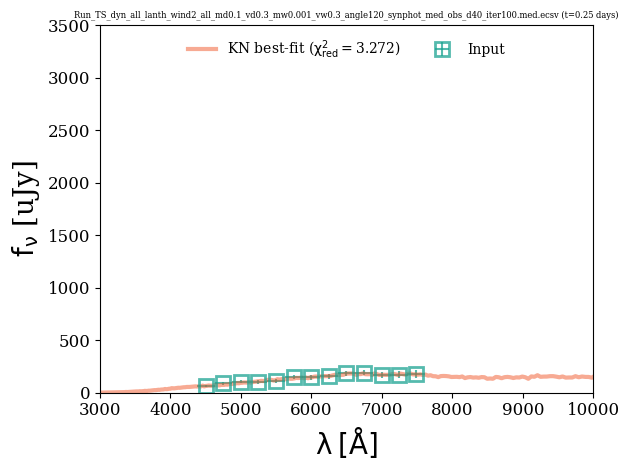

In [56]:
nrow_min = np.arange(len(sdtbl))[sdtbl['kn_rchisq'] == sdtbl['kn_rchisq'].min()].item()
nrow_max = np.arange(len(sdtbl))[sdtbl['kn_rchisq'] == sdtbl['kn_rchisq'].max()].item()
print(nrow_min)
plot_routine(intbl=sdtbl, nrow=nrow_min, lam=mlam, bdw=mbdw, path_obs='../5.result/kn_sim_cube_obs/med_iter100_40Mpc', path_plot='../5.result/fit_kn2all/7dt', seed=0, xl=3000, xr=10000)
# print(nrow_max)
# plot_routine(intbl=sdtbl, nrow=nrow_max, lam=mlam, bdw=mbdw, path_obs='../5.result/kn_sim_cube_obs/med_iter100_40Mpc', path_plot='../5.result/fit_kn2all/7dt', seed=0, xl=3000, xr=10000)


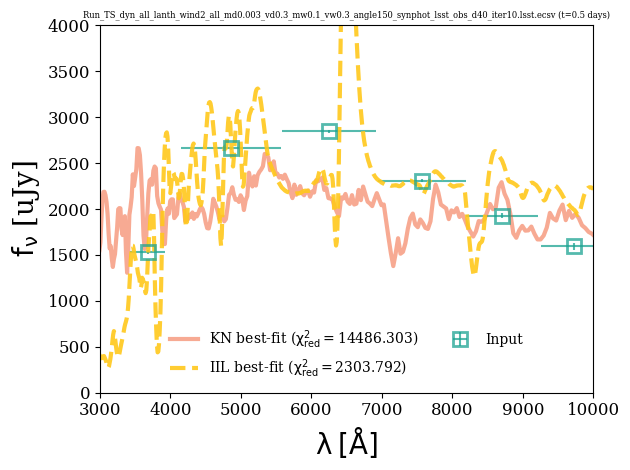

In [72]:
# indx_drchisq = np.where(
# 	(lstbl['del_rchisq']<0)
# 	)
# lstbl['obs'][indx_drchisq]
obs = lstbl['obs'][lstbl['del_rchisq'] == lstbl['del_rchisq'].min()].item()
t = lstbl['t'][lstbl['del_rchisq'] == lstbl['del_rchisq'].min()].item()
nrow = np.arange(len(lstbl))[lstbl['del_rchisq'] == lstbl['del_rchisq'].min()].item()
plot_routine(intbl=lstbl, nrow=nrow, lam=lsstlam, bdw=lsstbdw, path_obs='../5.result/kn_sim_cube_obs/lsst_30s_iter10_40Mpc', path_plot='../5.result/fit_kn2all/lsst', seed=0, xl=3000, xr=10000)



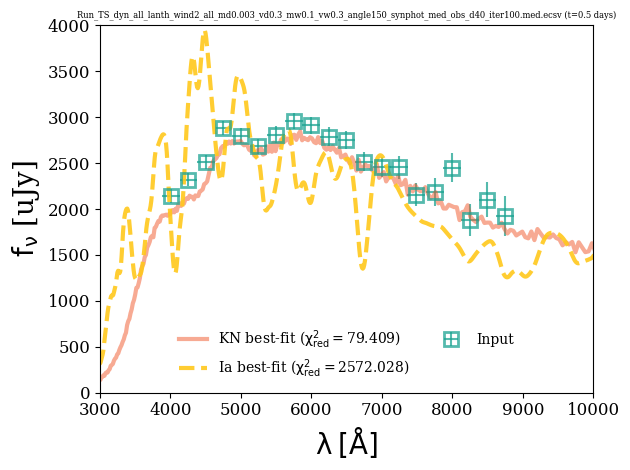

In [73]:
head = str(obs, 'utf-8').split('_synphot_')[0]
nrows = []
for oo, obs0 in enumerate(sdtbl['obs']):
	if head in obs0:
		# print(oo, obs0)
		nrows.append(oo)

for nrow in nrows[2:3]:
	plot_routine(intbl=sdtbl, nrow=nrow, lam=mlam, bdw=mbdw, path_obs='../5.result/kn_sim_cube_obs/med_iter100_40Mpc', path_plot='../5.result/fit_kn2all/7dt', seed=0, xl=3000, xr=10000)

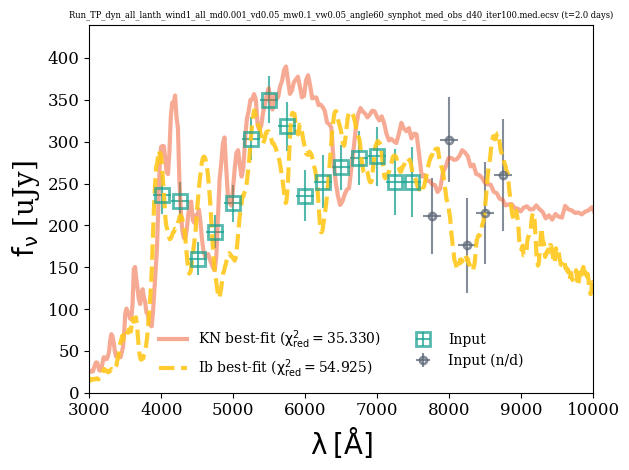

In [102]:
indx_iip = np.where(sdtbl[(sdtbl['typ']=='IIP') & (sdtbl['del_rchisq']>1000)])
indx_iip[0]

plot_routine(intbl=sdtbl, nrow=48, lam=mlam, bdw=mbdw, path_obs='../5.result/kn_sim_cube_obs/med_iter100_40Mpc', path_plot='../5.result/fit_kn2all/7dt', seed=0, xl=3000, xr=10000)

In [11]:
# failist = []
# for nrow in range(len(sdtbl)):
# 	try:
# 		print(f"[{nrow+1}/{len(sdtbl)}]"+" "*10, end='\r')
# 		plot_routine(intbl=sdtbl, nrow=nrow, lam=mlam, bdw=mbdw, path_obs='../5.result/kn_sim_cube_obs/med_iter100_40Mpc', path_plot='../5.result/fit_kn2all/7dt', seed=0, xl=3000, xr=10000)
# 	except:
# 		failist.append(nrow)


In [24]:
# failist = []
# for nrow in range(len(lstbl)):
# 	try:
# 		print(f"[{nrow+1}/{len(lstbl)}]"+" "*10, end='\r')
# 		plot_routine(intbl=lstbl, nrow=nrow, lam=lsstlam, bdw=lsstbdw, path_obs='../5.result/kn_sim_cube_obs/lsst_30s_iter10_40Mpc', path_plot='../5.result/fit_kn2all/lsst', seed=0, xl=3000, xr=10000)
# 	except:
# 		failist.append(nrow)



In [ ]:
# for nrow in range(len(lstbl)):
# 	print(f"[{nrow+1}/{len(lstbl)}]"+" "*10, end='\r')
# 	plot_routine(intbl=lstbl, nrow=nrow, lam=lsstlam, bdw=lsstbdw, path_obs='../5.result/kn_sim_cube_obs/lsst_30s_iter10_40Mpc', path_plot='../5.result/fit_kn2all/lsst', seed=0, xl=3000, xr=10000)
# for nrow in range(len(kmtbl)):
# 	print(f"[{nrow+1}/{len(kmtbl)}]"+" "*10, end='\r')
# 	plot_routine(intbl=kmtbl, nrow=nrow, lam=jclam, bdw=jcbdw, path_obs='../5.result/kn_sim_cube_obs/kmtnet_120s_iter10_40Mpc', path_plot='../5.result/fit_kn2all/kmtnet', seed=0, xl=3000, xr=10000)

